**ARSITEKTUR CNN - MODEL INCEPTION [GOOGLENET]**

In [ ]:
!pip uninstall -y tensorflow keras
!pip install tensorflow==2.16.1 keras==3.3.3

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0
Found existing installation: keras 2.15.0
Uninstalling keras-2.15.0:
  Successfully uninstalled keras-2.15.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 81.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 82.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 24.0 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully un

In [ ]:
import tensorflow as tf
import keras

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)


TensorFlow version: 2.16.1
Keras version: 3.3.3


In [2]:
# Import library yang dipakai
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import requests
import shutil
from PIL import Image
from io import BytesIO

# Import tensorflow
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import *
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

# Menghilangkan warning
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [5]:
# URL repositori GitHub (ganti dengan URL dataset Anda)
repo_url = 'https://github.com/antonwijayacakra/Datasheet-fundus-STQ-with-AI-.git'
repo_dir = 'dataset'

# Kloning repositori
os.system(f'git clone {repo_url} {repo_dir}')

0

In [6]:
# Load dataset paths and labels
base_dir = os.path.join(os.getcwd(), repo_dir, 'Split_DATASHEET_N_G_DR_Kelompok3')
train_dir = os.path.join(base_dir, 'Train')
valid_dir = os.path.join(base_dir, 'Validation')
test_dir = os.path.join(base_dir, 'Test')

In [7]:
# Periksa apakah folder dan file ada
if not os.path.exists(train_dir):
    raise FileNotFoundError(f"Folder {train_dir} tidak ditemukan.")

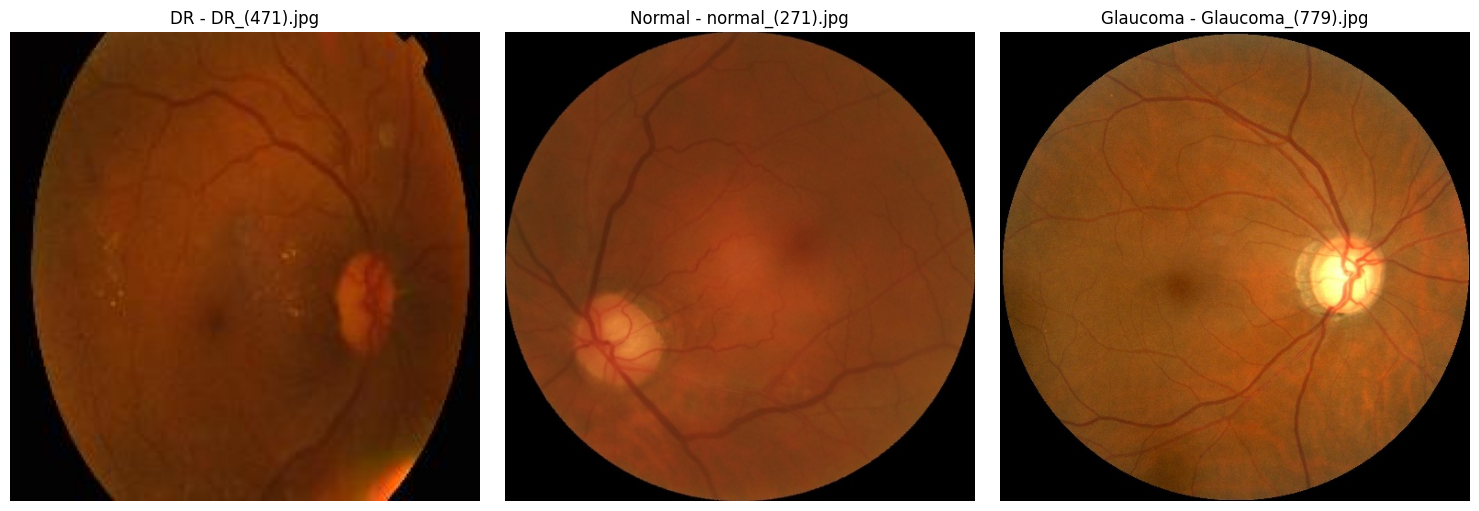

In [8]:
# Visualisasi beberapa gambar dari folder train
def plot_sample_images(base_path, classes, nrows=1, ncols=3):
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5))
    axes = axes.flatten()

    for i, class_name in enumerate(classes):
        folder_path = os.path.join(base_path, class_name)
        img_names = os.listdir(folder_path)
        random_img_name = random.choice(img_names)  # Memilih gambar secara acak
        img_path = os.path.join(folder_path, random_img_name)

        if os.path.isfile(img_path):
            img = mpimg.imread(img_path)
            axes[i].imshow(img)
            axes[i].set_title(f"{class_name} - {random_img_name}")
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Contoh visualisasi gambar secara acak dari kelas 'DR', 'Normal', dan 'Glaucoma' di folder train
plot_sample_images(train_dir, ['DR', 'Normal', 'Glaucoma'])

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_ds = validation_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_ds = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

# Print sample sizes
print(f'Training data samples: {train_ds.samples}')
print(f'Validation data samples: {validation_ds.samples}')
print(f'Test data samples: {test_ds.samples}')

Found 3300 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Training data samples: 3300
Validation data samples: 300
Test data samples: 300


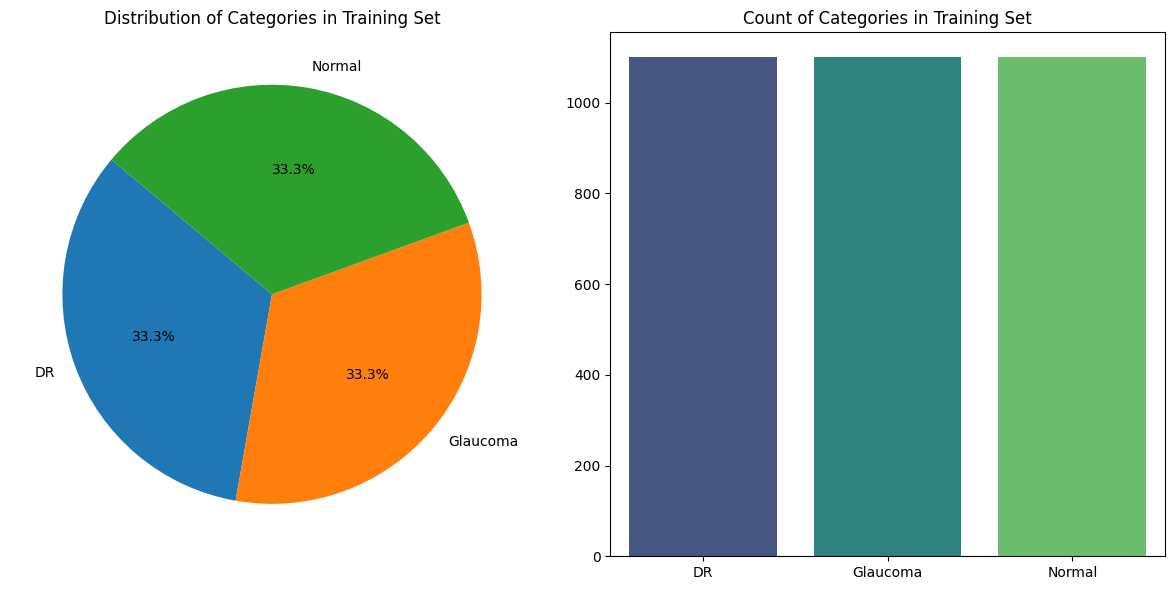

In [10]:
# Count the occurrences of each category in the training dataset
count = pd.Series(train_ds.classes).value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Plot pie chart on the first subplot
palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=train_ds.class_indices.keys(), autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories in Training Set')

# Plot bar chart on the second subplot
sns.barplot(x=list(train_ds.class_indices.keys()), y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Count of Categories in Training Set')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

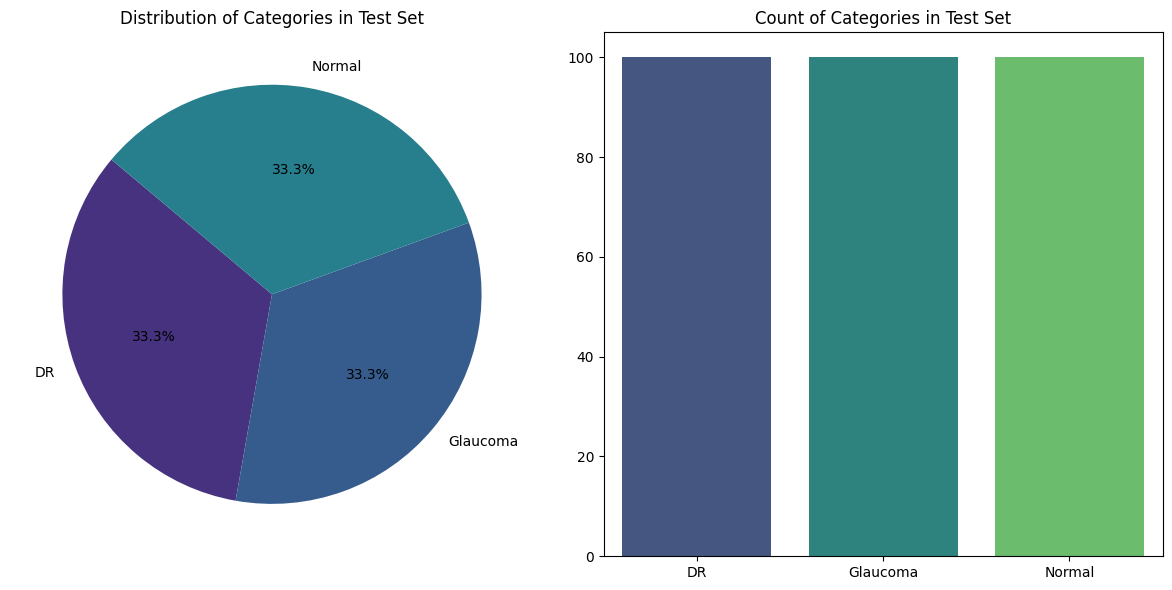

In [11]:
# Count the occurrences of each category in the test dataset
count = pd.Series(test_ds.classes).value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Plot pie chart on the first subplot
palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=test_ds.class_indices.keys(), autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories in Test Set')

# Plot bar chart on the second subplot
sns.barplot(x=list(test_ds.class_indices.keys()), y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Count of Categories in Test Set')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

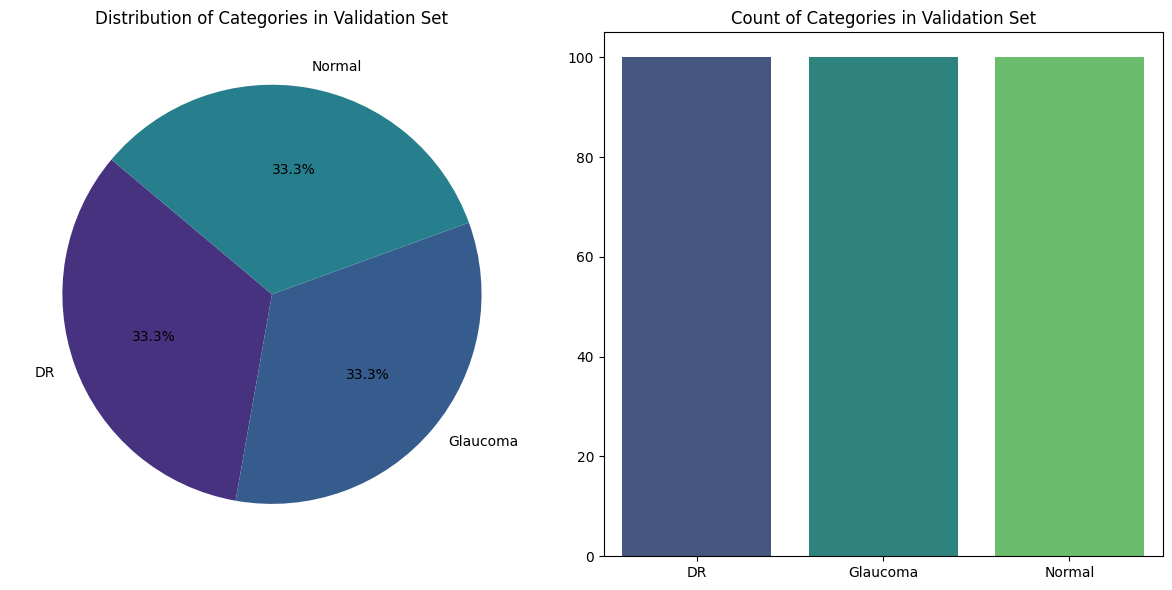

In [12]:
# Count the occurrences of each category in the validation dataset
count = pd.Series(validation_ds.classes).value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Plot pie chart on the first subplot
palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=validation_ds.class_indices.keys(), autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories in Validation Set')

# Plot bar chart on the second subplot
sns.barplot(x=list(validation_ds.class_indices.keys()), y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Count of Categories in Validation Set')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [13]:
def visualize_images(path, num_images=5):
    # Get a list of image filenames in the specified path
    image_filenames = os.listdir(path)

    # Limit the number of images to visualize if there are more than num_images
    num_images = min(num_images, len(image_filenames))

    # Create a figure and axis object to display images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')

    # Iterate over the selected images and display them
    for i, image_filename in enumerate(image_filenames[:num_images]):
        # Load the image using Matplotlib
        image_path = os.path.join(path, image_filename)
        image = mpimg.imread(image_path)

        # Display the image
        axes[i].imshow(image)
        axes[i].axis('off')  # Turn off axis
        axes[i].set_title(image_filename)  # Set image filename as title

    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()

In [14]:
base_model = InceptionV3(weights='imagenet', include_top=False)

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=20,
    callbacks=[early_stopping]
)

87910968/87910968 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, None, None, 2048   21802784  
                             )                                   
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                         

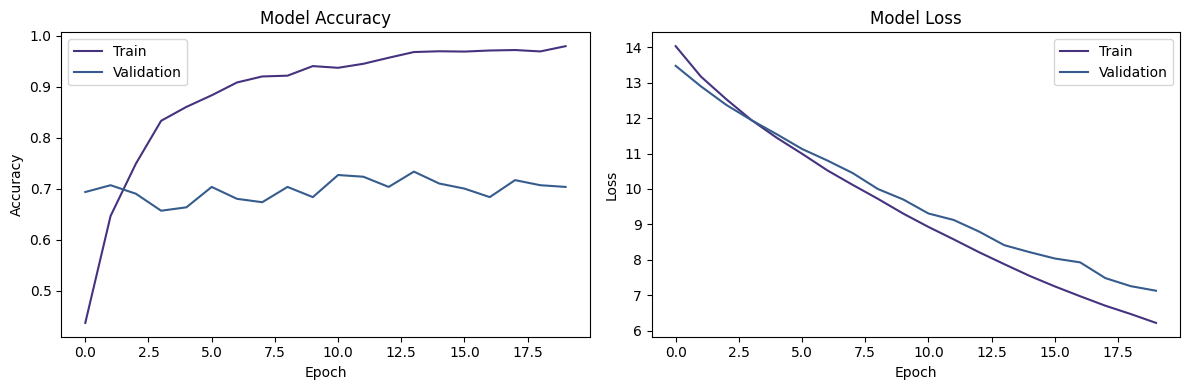

In [15]:
# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# Simpan model
model.save('model_inception.h5')

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


1/1 [==============================] - 1s 1s/step


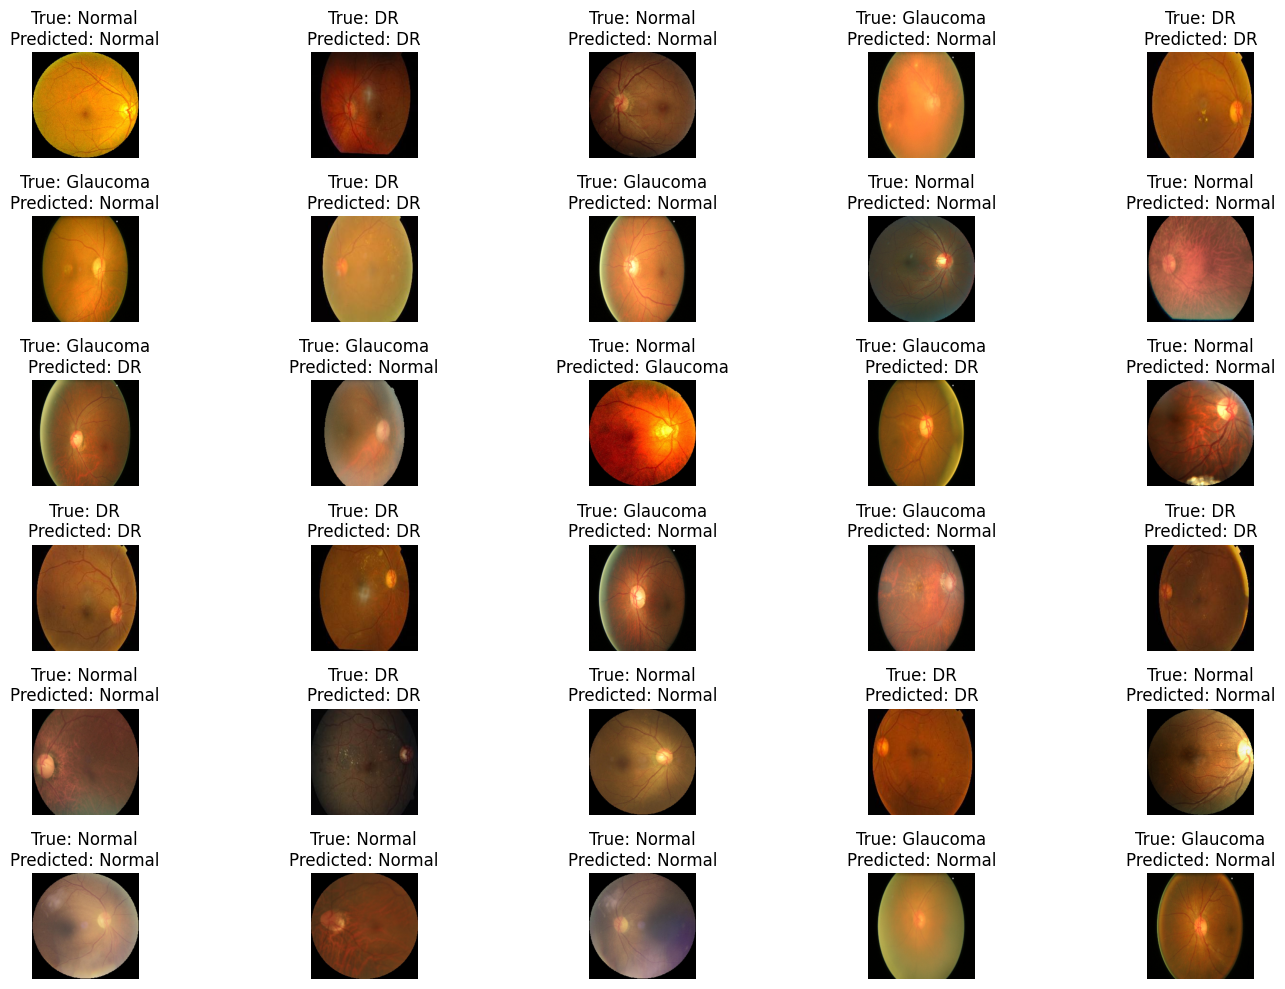

In [17]:
# Get the class labels
class_labels = list(test_ds.class_indices.keys())

# Predict on each image and plot results
num_images = 30
num_images_per_row = 5  # Set the number of images per row
num_rows = 6

plt.figure(figsize=(15, 10))
for i in range(num_images):
    image, label = next(test_ds)
    predictions = model.predict(image)

    # Iterate over each image in the batch
    for j in range(len(image)):
        if i * len(image) + j < num_images:  # Check if the total number of images exceeds the desired count
            predicted_class = class_labels[np.argmax(predictions[j])]
            true_class = class_labels[np.argmax(label[j])]

            plt.subplot(num_rows, num_images_per_row, i * len(image) + j + 1)
            plt.imshow(image[j])
            plt.title(f'True: {true_class}\nPredicted: {predicted_class}')
            plt.axis('off')

plt.tight_layout()
plt.show()
